In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
os.chdir('../')

In [2]:
from utils_analysis import logs_to_plot

from delfi.distribution import Uniform
from delfi.generator import Default
from delfi.inference import SNPE  # , Basic, CDELFI

from dap.utils import (obs_params, syn_obs_stats, syn_obs_data,
                       load_current, load_prior_ranges)
from dap.dap_sumstats_moments import DAPSummaryStatsMoments
from dap.dap_simulator import DAPSimulator
from dap import DAPcython

In [3]:
name = '_test_save'
directory = 'pickle/dap_model' + name
direct_out = 'plots/dap_models' + name + '/'

n_hiddens = [6]
n_samples = 1000
n_rounds = 1
n_params = 2

n_summary = 17
n_components = 1
reg_lambda = 0.01

In [4]:
# picking experiments observables
observables = {'loss.lprobs', 'imputation_values', 'h1.mW', 'h1.mb', 'h2.mW',
               'h2.mb', 'weights.mW', 'weights.mb', 'means.mW0', 'means.mW1',
               'means.mb0', 'means.mb1', 'precisions.mW0', 'precisions.mW1',
               'precisions.mb0', 'precisions.mb1'}

In [5]:
# Load the current
data_dir = '/home/alteska/Desktop/LFI_DAP/data/rawData/2015_08_26b.dat'    # best cell
protocol = 'rampIV' # 'IV' # 'rampIV' # 'Zap20'
ramp_amp = 3.1
I, v, t, t_on, t_off, dt = load_current(data_dir, protocol=protocol, ramp_amp=ramp_amp)
I_step, v_step, t_step, t_on_step, t_off_step, dt_step = load_current(data_dir, protocol='IV', ramp_amp=1)
Istep = I_step[2500:18700]
vstep = v_step[2500:18700]

In [6]:
# Set up themodel
params, labels = obs_params(reduced_model=True)
dap = DAPcython(-75, params)
U = dap.simulate(dt, t, I)
U_step = dap.simulate(dt_step, t_step, Istep)

In [7]:
# generate data format for SNPE / OBSERVABLE
x_o = {'data': v.reshape(-1),
       'time': t,
       'dt': dt,
       'I': I}

In [8]:
# Setup Priors
prior_min, prior_max, labels = load_prior_ranges(n_params)
prior_unif = Uniform(lower=prior_min, upper=prior_max)
print(prior_min, prior_max, labels)

[3.274 0.1  ] [27.263  2.   ] ['gbar_nap', 'gbar_leak']


In [9]:
# Summary Statistics
S = syn_obs_stats(x_o['I'], params=params, dt=x_o['dt'], t_on=t_on, t_off=t_off,
                  n_summary=n_summary, summary_stats=0, data=x_o)

M = DAPSimulator(x_o['I'], x_o['dt'], -75)

s = DAPSummaryStatsMoments(t_on, t_off, n_summary=n_summary)
G = Default(model=M, prior=prior_unif, summary=s)  # Generator

In [10]:
# Runing the simulation
inf_snpe = SNPE(generator=G, n_components=n_components, n_hiddens=n_hiddens, obs=S,
                reg_lambda=reg_lambda, pilot_samples=0)

In [11]:
# inf_snpe.centre_on_obs()
# inf_snpe.conditional_norm()
inf_snpe.standardize_init()

obs (1, 12)
mean (1, 12)
std (12,)


In [12]:
logs, tds, posteriors = inf_snpe.run(n_train=[n_samples], n_rounds=n_rounds,
                                     proposal=prior_unif, monitor=observables)

Training (round 1) : 100%|██████████| 100000/100000 [00:01<00:00, 89354.26it/s]


In [13]:
logs2, tds2, posteriors2 = inf_snpe.run(n_train=[n_samples], n_rounds=n_rounds,
                                     proposal=prior_unif, monitor=observables)

Training (round 2) : 100%|██████████| 100000/100000 [00:01<00:00, 80436.53it/s]


In [14]:
# Analyse results
samples_prior = prior_unif.gen(n_samples=int(5e5))
samples_posterior = posteriors[-1].gen(n_samples=int(5e5))

print('posterior:', posteriors[-1].mean)

x_post = syn_obs_data(I, dt, posteriors[-1].mean)
x_post_step = syn_obs_data(I_step, dt, posteriors[-1].mean)

idx = np.arange(0, len(x_o['data']))

posterior: [3.09403279 1.28463967]


In [15]:
# Analyse results
samples_posterior2 = posteriors2[-1].gen(n_samples=int(5e5))

print('posterior:', posteriors2[-1].mean)

x_post2 = syn_obs_data(I, dt, posteriors2[-1].mean)
x_post_step2 = syn_obs_data(I_step, dt, posteriors[-1].mean)


posterior: [3.23580399 1.3031866 ]


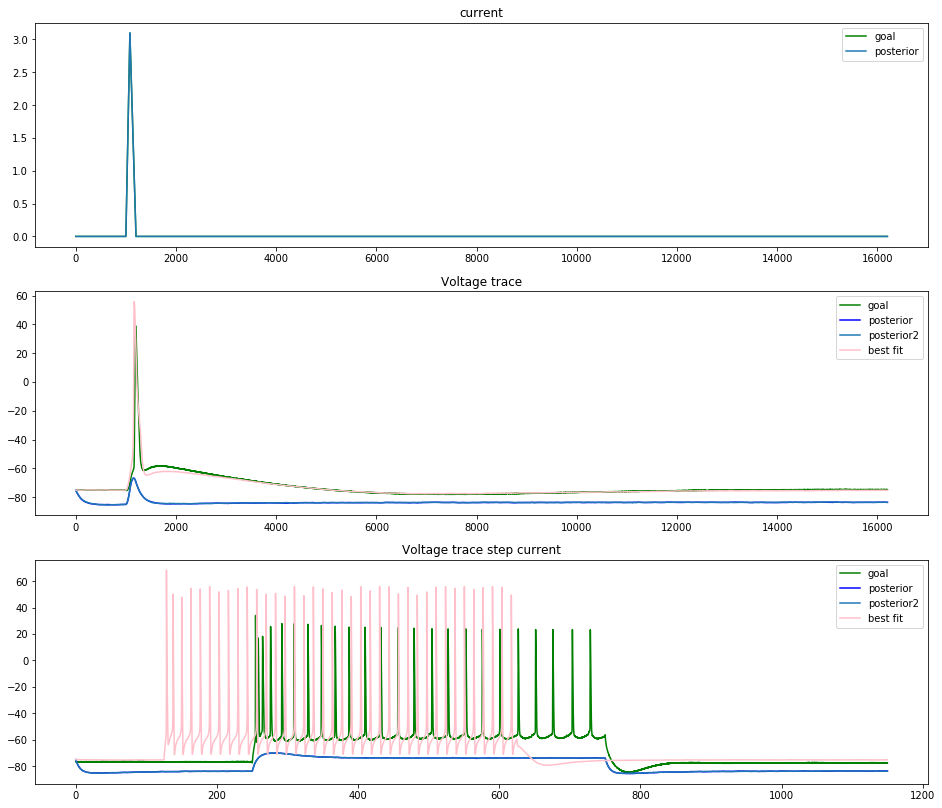

In [16]:
# Create Plots
simulation, axes = plt.subplots(3, 1, figsize=(16,14))
axes[0].plot(idx, x_o['I'], c='g', label='goal')
axes[0].plot(idx, x_post['I'], label='posterior')
axes[0].set_title('current')
axes[0].legend()

axes[1].plot(idx, x_o['data'], c='g', label='goal')
axes[1].plot(idx, x_post['data'], c='b', label='posterior')
axes[1].plot(idx, x_post2['data'], label='posterior2')
axes[1].plot(idx, U, c='pink', label='best fit')
axes[1].set_title('Voltage trace')
axes[1].legend()

axes[2].plot(t_step, v_step, c='g', label='goal')
axes[2].plot(t_step, x_post_step['data'], c='b', label='posterior')
axes[2].plot(t_step, x_post_step2['data'], label='posterior2')
axes[2].plot(t_step, U_step, c='pink', label='best fit')
axes[2].set_title('Voltage trace step current')
axes[2].legend()

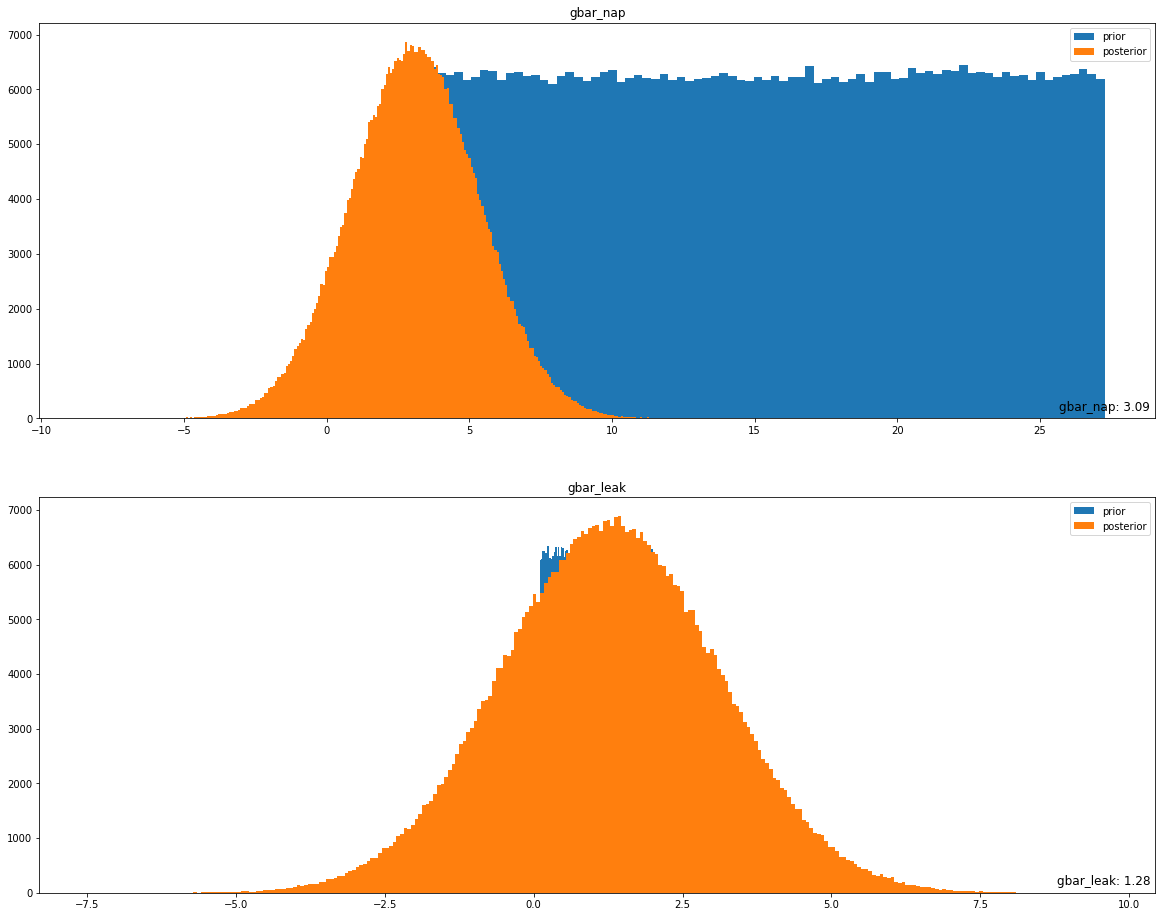

In [17]:
distr_comb, axes = plt.subplots(nrows=n_params, figsize=(20, 16))
for ii, l in enumerate(labels):

    axes[ii].hist(samples_prior[:, ii], bins='auto', label='prior')
    axes[ii].hist(samples_posterior[:, ii], bins='auto', label='posterior')

    axes[ii].set_title(l)
    axes[ii].annotate(l+': '+str(round(posteriors[-1].mean[ii], 2)),
                    xy=(1, 0), xycoords='axes fraction', fontsize=12,
                    xytext=(-5, 5), textcoords='offset points',
                    ha='right', va='bottom')

    axes[ii].legend()

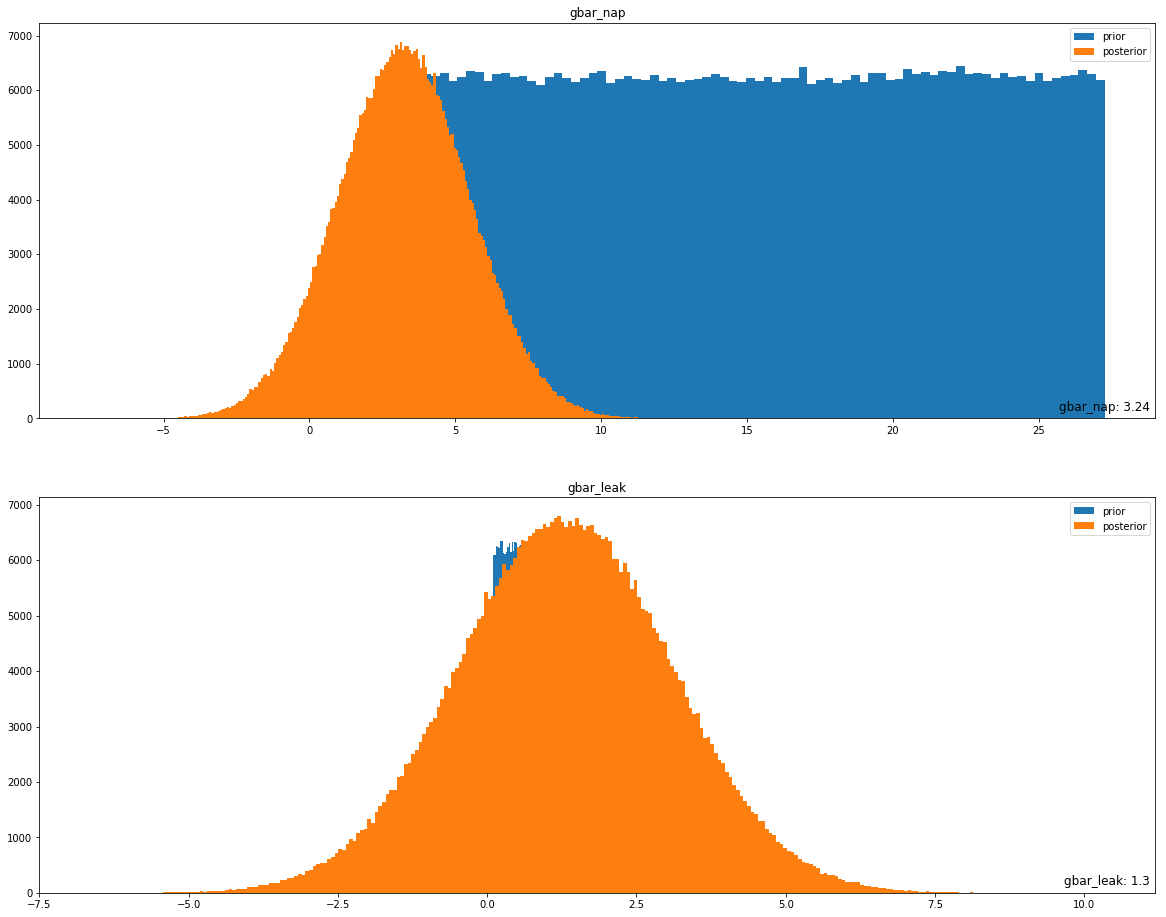

In [18]:
distr_comb, axes = plt.subplots(nrows=n_params, figsize=(20, 16))
for ii, l in enumerate(labels):

    axes[ii].hist(samples_prior[:, ii], bins='auto', label='prior')
    axes[ii].hist(samples_posterior2[:, ii], bins='auto', label='posterior')

    axes[ii].set_title(l)
    axes[ii].annotate(l+': '+str(round(posteriors2[-1].mean[ii], 2)),
                    xy=(1, 0), xycoords='axes fraction', fontsize=12,
                    xytext=(-5, 5), textcoords='offset points',
                    ha='right', va='bottom')

    axes[ii].legend()

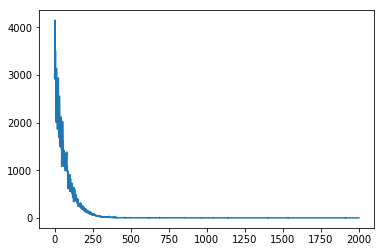

In [19]:
loss, ax = plt.subplots(1,1)
ax.plot(logs[0]['loss'])

In [20]:
# Save hyperparameters
hyper = {
    'name': name,
    'means': str(posteriors[-1].mean),
    'n_rounds': n_rounds,
    'n_summary': n_summary,
    'n_samples': n_samples,
    'n_hidden': str(n_hiddens),
    'n_components': n_components,
    'protocol': protocol,
    'ramp_amp': ramp_amp,
    'prior_min': str([0, 1]),
    'prior_max': str([0.5, 30]),
}

hyperparams = pd.DataFrame(hyper, index=[0])
hyperparams


,name,means,n_rounds,n_summary,n_samples,n_hidden,n_components,protocol,ramp_amp,prior_min,prior_max
0,_test_save,[3.09403279 1.28463967],1,17,1000,[6],1,rampIV,3.1,"[0, 1]","[0.5, 30]"


In [21]:
# Save parameters
parameters = pd.DataFrame(data=posteriors[-1].mean, index=labels,
                          columns=['mean param'])
parameters

,mean param
gbar_nap,3.094033
gbar_leak,1.284640
